# English to French Translation 
## Seq2Seq (Encoder/Decoder) Model From Scratch

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html  


While recurrent nets allow us to process sequential data, things get tricky with *sequence length*. We can use an RNN (or variant) to process a sequence and convert that into a classification or regression (for example, language of origin for a name). We can even use a single RNN to learn to predict the next character in a sequence of text, allowing us to generate text.  
However, things break down when we want to predict a **sequence** of outputs, rather than a single/time-invariant output (like a class or a preceding character).  
This is where the encoder/decoder model comes in - one RNN is used to process the sequential data, producing a single output (the last hidden state at the end of its loop) which ideally encodes all the useful information about the sequence.  
Then a seperate RNN, the decoder, takes in the encoder's output and uses it to generate a sequence of output, with some other tricks lending a hand.  

### Encoder:  
I use a GRU as my recurrent component and additionally use an 'embedding layer' before the GRU. Thus the encoder receives a character, embeds the character, and passes the embedding and the hidden state into the GRU. The GRU uses the embedding and hidden state to update the hidden state. This repeats for every character in the sequence, and the final hidden state is the GRU's output.  

### Simple Decoder:  
The last output of the encoder (ie, last hidden state of the GRU) is also known as the 'context vector' since it has seen the entire input sequence. For a simple seq2seq model implementation we can just use this last vector as the initial hidden state for the GRU in the decoder component.  
The GRU also receives an input character - which to start is a special "start of phrase" token. Once again we can use a learnable embedding layer to embed this token before passing it into the GRU.  
For every input character, the decoder outputs an updated hidden state and a prediction of the next character. These get passed back into the GRU until it predicts the special "end of phrase" token.    

Finally, we backprop through the whole network and update its parameters.  

### Attention Decoder
It's a lot to ask of the encoder to produce a single hidden state (context vector) which helpfully describes the entire input sequence.  
The purpose of 'attention' is to allow the decoder network to focus on a specific part of the encoder's outputs for each step of its own process. Thus, we will store all of the encoder GRU's outputs during the encoding phase.  


We calculate attention weights using a layer which is fed the decoder's current input and previous hidden state (to start we use the encoder's context vector / last hidden state as the previous hidden state).  
The result is softmaxed (numbers squished between 0 and 1) and matrix multiplied directly with the encoder's outputs, effectively weighting the outputs before they can be passed into the decoder's GRU.   
These outputs are also passed through a ReLU layer before being passed into the decoder GRU with the previous hidden state, and the GRU produces a new hidden state which is used to a) make a prediction over the next character and b) repeat the cycle.  

This learnable attention layer ideally helps the model focus on the most important part of the encoder's output for each step in the decoding.  

To apply this (relatively simple) attention layer, we have to specify a maximum phrase length for the inputs. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few (since the rest of the encoder output matrix will be zero).  

## Training:  
In this tutorial the author also demonstrates "teacher forcing", a training method where the decoder is shown the true target output character to use as its input when predicting the next character. It's as if we are teaching the model, rather than simply allowing it to learn.    
Rather than applying this method every time, we randomly choose for each sample whether to use teacher forcing. This likelihood of using teacher forcing is a controllable parameter.   



In [993]:
# Text preprocessing
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
from typing import Union
import numpy as np
import re


# Model/Train Helpers
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

from google_trans_new import google_translator  


# PyTorch
import torch
import torch.nn as nn

In [1109]:
def plot_grad_flow_basic(raw_parameters : list, param_names : list=None):
    '''
    Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Provide the list of raw model parameters.
    Adapted from source: https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/10
    '''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in enumerate(raw_parameters):
        if(p.requires_grad) & (p.grad is not None): #and ("bias" not in n):
            layers.append(str(n))
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())

    xticks = range(0,len(ave_grads), 1)
    y_min = min(ave_grads)
    y_max = (sum(ave_grads)/len(ave_grads))
    if param_names is not None:
        for x_ix in xticks:
            plt.text(x_ix, y_max/3, s=param_names[x_ix], rotation=90)

    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(xticks, layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = y_min, top=y_max) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [1532]:
class TranslGRU:
    def __init__(self, vocab_size, 
                       enc_embed_dim, dec_embed_dim,
                       dec_type, hidden_size, max_length,
                       stoi_mapping, start_chr, stop_chr
                ) -> None:
        """
        Define an Encoder-Decoder network each consisting of a GRU for sequence to sequence translation.
        n_letters = number of unique letters/characters that appear in the data.
        embed_dim = dimension of the embedding layer
        dec_type = "simple" or "attention"  
        hidden_size = desired number of elements in the hidden and cell states
        output_size = Dense layer ontop of the decoder converts last hidden state to logits of shape (output_size, 1)
        """
        # Model architecture
        self.input_size = vocab_size
        
        self.enc_embed_dim = enc_embed_dim
        self.dec_embed_dim = dec_embed_dim
        self.dec_type = dec_type
        self.max_length = max_length

        self.enc_hidden_size = hidden_size ## technically the dec hidden size has to be the same as the encoder rn
        self.dec_hidden_size = hidden_size ##

        self.output_size = n_letters
        
        # Data processing
        self.stoi = stoi_mapping
        self.itos = {i:s for s, i in stoi_mapping.items()}

        assert start_chr in stoi_mapping
        assert stop_chr in stoi_mapping
        self.start_chr_ix = stoi_mapping[start_chr]
        self.stop_chr_ix = stoi_mapping[stop_chr]

    def init_weights(self, lam=0.01, seed=123) -> None:
        """Initialize weight tensors for the model."""
        g = torch.Generator().manual_seed(seed)

        self.params = []
        self.param_names = []

        self._init_enc_weights(lam=lam, g=g)
        self._init_dec_weights(lam=lam, g=g)
        
        for p in self.params:
            p.requires_grad = True 
        self.n_parameters = self._count_params()

    def init_hidden(self) -> torch.tensor:
        """Initialize hidden state. Returns: hidden"""
        hidden = torch.zeros((self.enc_hidden_size, 1))  #(hidden size , batch size)
        return hidden


    def _init_enc_weights(self, g, lam=0.01, ) -> None:
        """Initialize weight tensors for the decoder model."""
        concat_size = self.enc_embed_dim + self.enc_hidden_size

        self.enc_embed = torch.rand((self.input_size, self.enc_embed_dim), generator=g) * lam

        self.enc_W_reset = torch.rand((self.enc_hidden_size, concat_size), generator=g) * lam
        self.enc_br = torch.zeros((self.enc_hidden_size, 1)) * lam
        self.enc_W_update = torch.rand((self.enc_hidden_size, concat_size), generator=g) * lam
        self.enc_bu = torch.zeros((self.enc_hidden_size, 1)) * lam
        self.enc_W_htilde = torch.rand((self.enc_hidden_size, concat_size), generator=g) * lam
        #self.bh = torch.zeros((self.hidden_size, 1)) * lam
        
        self.params += [self.enc_embed, self.enc_W_reset, self.enc_br, self.enc_W_update, self.enc_bu, self.enc_W_htilde]
        self.param_names += ['enc_embed', 'enc_W_reset', 'enc_br', 'enc_W_update', 'enc_bu', 'enc_W_htilde']
        
    def _init_dec_weights(self, g, lam=0.01) -> None:
        """Initialize weight tensors for the decoder."""
        concat_size = self.dec_embed_dim + self.dec_hidden_size

        if self.dec_type == "attention":
            self.W_att = torch.rand((self.max_length, concat_size), generator=g) * lam
            self.ba = torch.zeros((self.max_length, 1)) * lam
            self.W_rel = torch.rand((self.dec_embed_dim, concat_size), generator=g) * lam
            self.brel = torch.zeros((self.dec_embed_dim, 1)) * lam

            self.params += [self.W_att, self.ba, self.W_rel, self.brel]
            self.param_names += ['W_att', 'ba', 'W_rel', 'brel']

        self.dec_embed = torch.rand((self.input_size, self.dec_embed_dim), generator=g) * lam
        self.dec_W_reset = torch.rand((self.dec_hidden_size, concat_size), generator=g) * lam
        self.dec_br = torch.zeros((self.dec_hidden_size, 1)) * lam
        self.dec_W_update = torch.rand((self.dec_hidden_size, concat_size), generator=g) * lam
        self.dec_bu = torch.zeros((self.dec_hidden_size, 1)) * lam
        self.dec_W_htilde = torch.rand((self.dec_hidden_size, concat_size), generator=g) * lam
        #self.bh = torch.zeros((self.hidden_size, 1)) * lam
        # FC HEAD
        self.W_h2o = torch.rand((self.output_size, self.dec_hidden_size), generator=g) * lam
        self.b_h20 = torch.zeros((self.output_size, 1)) * lam

        self.params += [self.dec_embed, self.dec_W_reset, self.dec_br, self.dec_W_update, self.dec_bu, self.dec_W_htilde, self.W_h2o, self.b_h20]
        self.param_names += ['dec_embed', 'dec_W_reset', 'dec_br', 'dec_W_update', 'dec_bu', 'dec_W_htilde', 'W_h2o', 'b_h20']


    def encoder(self, hidden_prev, x_tensor_t):
        "ENCODER AT STEP T"
        input = self.enc_embed[x_tensor_t].unsqueeze(dim=1)
        hidden_new = self.gru(input, hidden_prev, self.enc_W_reset, self.enc_br, self.enc_W_update, self.enc_bu, self.enc_W_htilde)
        return hidden_new
    
    def simple_decoder(self, context_vector, input_char_t):
        "DECODER AT STEP T"
        input = self.dec_embed[input_char_t].unsqueeze(dim=1)
        hidden_new = self.gru(input, context_vector, self.dec_W_reset, self.dec_br, self.dec_W_update, self.dec_bu, self.dec_W_htilde)
        
        # run hidden state through linear layer to predict next char
        # output = torch.softmax(self.linear(hidden_new))
        logits = self.linear_head(hidden_new)
        next_input_char = int(torch.argmax(logits, dim=0).item()) ##return just the index

        return hidden_new, logits, next_input_char
    
    def attention_decoder(self, enc_outputs, prev_hidden, input_char_t):
        "ATTENTION DECODER AT STEP T"
        # embed the current character and concatenate with previous hidden state
        embeded = self.dec_embed[input_char_t].unsqueeze(dim=1) ##shape embed_dim, 1
        concat1 = torch.cat((embeded, prev_hidden), dim=0)      ##shape embed_dim+hidden_size, 1
        # calculate attention weights by passing in the concatenation & softmaxing
        # apply the attention vector to the context vector
        atten = torch.nn.functional.softmax(self.linear_attention(concat1), dim=0).T ##shape 1, max_len. & enc_outputs have shape max_len, hidden_size
        atten_weighted = (atten @ enc_outputs).squeeze(dim=0)             ##shape hidden_size
        ## attention vector is broadcast over the entire enc output matrix (where each row is a hidden state), weighting

        # concat the attention-weighted context with the input embedding and pass through a ReLU linear layer
        concat2 = torch.cat((embeded, atten_weighted.unsqueeze(dim=1)), dim=0)          ##shape embed_dim+hidden_size, 1
        gru_input = torch.nn.functional.relu(self.linear_relu(concat2))                 ##shape embed_dim, 1

        # pass the attention-processed inputs into the decoder gru along with previous hidden state to generate new hidden
        hidden_new = self.gru(gru_input, prev_hidden, self.dec_W_reset, self.dec_br, self.dec_W_update, self.dec_bu, self.dec_W_htilde)

        # run hidden state through linear layer to predict next char
        logits = self.linear_head(hidden_new)  
        next_input_char = int(torch.argmax(logits, dim=0).item())
        
        return hidden_new, logits, next_input_char
    
    def gru(self, input, hidden,
                  W_reset, br,
                  W_update, bu,
                  W_htilde
                  ) -> torch.tensor:
        """One forward step in a GRU cell to update hidden state. Returns: hidden_new"""
        # Concatenate inputs with incoming hidden state
        concat_raw = torch.cat((input, hidden), dim=0)

        # Calc reset gate and apply to hidden state to produce gated/reset hidden state
        r_gate = torch.sigmoid(W_reset @ concat_raw + br)
        hidden_reset = hidden * r_gate

        # Concatenate inputs with gated hidden state
        concat_gated = torch.cat((input, hidden_reset), dim=0)
        # Calculate h tilde, the proposed new hidden state, using the gated concatenation
        h_tilde = torch.tanh(W_htilde @ concat_gated)

        # Calc update gate using the raw/ungated concatenation
        u_gate = torch.sigmoid(W_update @ concat_raw + bu)

        # Update hidden state with (1 - update gate) * hidden_t-1 + (update gate * h tilde):
        hidden_new = (1 - u_gate) * hidden + u_gate * h_tilde
        
        return hidden_new
    
    def linear_head(self, input):
        return ( (self.W_h2o @ input) + self.b_h20 )

    def linear_attention(self, input):
        return self.W_att @ input + self.ba

    def linear_relu(self, input):
        return self.W_rel @ input + self.brel

    def backprop_update(self, lr) -> None:
        """Zero gradients, backpropogate, and update params with -lr*gradient"""
        # ensure gradients are zerod
        for p in self.params:
            p.grad = None

        # backprop
        self.loss.backward()

        # update
        for i, p in enumerate(self.params):
            if p.grad is None:
                print(i) ##silly debugging
            p.data += -lr * p.grad


    def _count_params(self):
        n_params = 0
        for p in self.params:
            n_params += p.nelement()
        return n_params

    def forward(self, x:torch.tensor, y:torch.tensor=None, teacher_forcing_ratio=0.0, max_length=100):
        """
        Perform an entire forward pass of one sample to calculate outputs and calculate loss if y is provided.
        Returns output_chars, loss.
        """

        # Determine maximum length to predict for
        if y is None:
            target_length = max_length
        else:
            target_length = y.shape[0]
            # y_ohe = torch.nn.functional.one_hot(y, num_classes=self.output_size)


        # ENCODER
        # Tensor to store the encoder gru's outputs at each timestep (as columns)
        enc_outputs = torch.zeros((self.max_length, self.enc_hidden_size))
        # Initialize hidden state with zeros
        enc_hidden = self.init_hidden()

        # Pass through X sequentially into the encoder and update hidden state
        loss = 0
        for t in range(x.shape[0]):
            enc_hidden = self.encoder(hidden_prev=enc_hidden, x_tensor_t=x[t])
            enc_outputs[t] = enc_hidden.squeeze(1)
        
        # encoder passes the finall hidden state (context vector) to simple decoder or attention decoder
        # the attention decoder also uses the enc_outputs matrix (ie, it uses all of the hidden states produced in the loop above)

        # DECODER
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False ##returns True if the float between [0, 1] is less than ratio
        output_chrs = []
        dec_hidden = enc_hidden ##last enc hidden state is the first context vector for simple decoder/first hidden state for attention decoder

        # Use the final hidden state (context vector) and the start token to start the decoding and predict the next character in the sequence
        # Repeat until the stop token is predicted or the target length is reached
        input_chr = self.start_chr_ix 
        for t in range(target_length):
            # SIMPLE
            if self.dec_type=="simple":
                # The last encoder hidden vector is 
                dec_hidden, logits, input_chr = self.simple_decoder(context_vector=dec_hidden, input_char_t=input_chr)
                output_chrs.append(input_chr)
            
            # ATTENTION
            if self.dec_type=="attention":
                dec_hidden, logits, input_chr = self.attention_decoder(enc_outputs=enc_outputs, 
                                                                       prev_hidden=dec_hidden,
                                                                       input_char_t=input_chr)  ##returns predicted character
                output_chrs.append(input_chr)

            if y is not None:
                loss += torch.nn.functional.cross_entropy(logits.squeeze(), y[t])

            if input_chr == self.stop_chr_ix:
                break

            if use_teacher_forcing:
                # overwrite the predicted input_chr since we will give the model the true input chr
                input_chr = y[t].item()
        
        # Save final loss for backpropagation through time
        self.loss = loss

        return output_chrs, loss
    
    def evaluate(self, english_text:str="Hello.", check_google=False):
        """Forward passes english_txt + 'stop_chr' through the model"""
        english_text_ = english_text+"<"
        input = torch.tensor([self.stoi[c] for c in english_text_])

        with torch.no_grad():
            for t in range(input.shape[0]):
                output, loss = self.forward(input, y=None)

        pred_transl, _ = self.decode_output(output)

        if check_google:
            try:
                translator = google_translator()
                google_transl = translator.translate(english_text, lang_src='en', lang_tgt='fr')
            except:
                google_transl = "Error accessing Google translate."
            return pred_transl, google_transl
        else:
            return pred_transl

    def decode_output(self, output, label=None):
        """Returns predicted translation, true translation ( = None if label is None)"""
        pred = []
        truth = [] if label is not None else None
        
        # input = [itos[ix.item()] for ix in x]
        for i in range(len(output)):
            pred.append(self.itos[output[i]])
        if label is not None:
            for i in range(len(label)):
                truth.append(self.itos[label[i].item()])
            
        pred_transl = "".join(pred)
        true_transl = "".join(truth) if label is not None else None
        return pred_transl, true_transl    



## Prep Data

In [1042]:
def words_to_data(eng, fra, stoi, stop_char:str):
    """
    Takes words list and breaks into training samples such that
    block_size characters are used to predict the following character.
    Returns X, Y (inputs and labels), where each sample in X is a tensor containing block_size elements
    and each sample in Y is a tensor containing one element.
    """

    # Data
    ## block_size = context length: how many chars do we use to predict the next?
    X, Y = [], []
    for en, fr in zip(eng, fra):
        
        # diff = len(fr) - len(en)
        # if diff > 0:
        #     add_to_en = abs(diff)
        #     add_to_fr = 0
        # elif diff < 0:
        #     add_to_en = 0
        #     add_to_fr = abs(diff)
        # else:
        #     add_to_en = 0
        #     add_to_fr = 0

        english_ix, french_ix = [], []
        for ch in en:
            english_ix.append(stoi[ch])
        english_ix.append(stoi[stop_char])
        # english_ix += [stoi[stop_char]] * add_to_en

        for ch in fr:
            french_ix.append(stoi[ch])
        french_ix.append(stoi[stop_char])
        # french_ix += [stoi[stop_char]] * add_to_fr

        X.append(torch.tensor(english_ix))
        Y.append(torch.tensor(french_ix))

    return X, Y


def split_samples(inputs, labels, frac=0.8, seed=123):
    "Split xs and ys (inputs and labels) into train and test sets"
    
    assert len(inputs)==len(labels), f"{len(inputs) = } which does not match {len(labels) = }"
    # generate a list of indices to exclude. Turn in into a set for O(1) lookup time
    random.seed(seed)
    indx = list(set(random.sample(list(range(len(inputs))), int(frac*len(inputs)))))

    x_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    x_mask[indx] = True

    y_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    y_mask[indx] = True

    train_x = inputs[x_mask]
    train_y = labels[y_mask]

    test_x = inputs[~x_mask]
    test_y = labels[~y_mask]

    return train_x, train_y, test_x, test_y

In [447]:
def import_data(max_english_chars, max_french_chars):
    english, french = [],[]

    matches = ["(", "‽", "…", "€"]
    with open("./data/rnn_tut_data/eng-fra.txt", encoding="utf-8") as file:
        for line in file:
            line = line.rstrip()
            line = line.replace(u"\u202f", " ")
            line = line.replace(u"\u3000", " ")
            line = line.replace(u"\u2000", " ")
            line = line.replace(u"\u200b", " ")
            line = line.replace(u"\xa0", " ")
            line = line.replace(u"\xad", " ")
            line = line.replace(u"\u2009", " ")
            line = line.replace("ú", "u")
            line = line.replace("–", "-")
            line = line.replace("а", "a")
            line = line.replace("‐", "-")
            line = line.replace("₂", "2")
            line = line.replace("\'", "'")
            if any(s in line for s in matches): ##removes some edge cases
                pass
            else:        
                eng, fra = line.split('\t')
            
            if (len(fra)>max_french_chars) | (len(eng)>max_english_chars):
                pass
            else:
                english.append(eng)
                french.append(fra)
    return english, french

In [1567]:
MAX_CHARS = 30
START_CHR = '>'
STOP_CHR = '<'

english, french = import_data(max_english_chars=MAX_CHARS, max_french_chars=MAX_CHARS) 

print(len(english))
print(len(french))

eng_chars = set(''.join(english))
fra_chars = set(''.join(french))
all_chars = set(''.join(english + french))

print(len(eng_chars))
print(len(fra_chars))
print(len(all_chars))

stoi = {s:i+2 for i, s in enumerate(all_chars)} ##create dictionary mapping from char to int
stoi[START_CHR] = 1
stoi[STOP_CHR] = 0
itos = {i:s for s, i in stoi.items()}


print("max english length = ", len(max(english, key=len)), "chars")
print("max french length = ", len(max(french, key=len)), "chars")

51177
51177
76
98
98
max english length =  30 chars
max french length =  30 chars


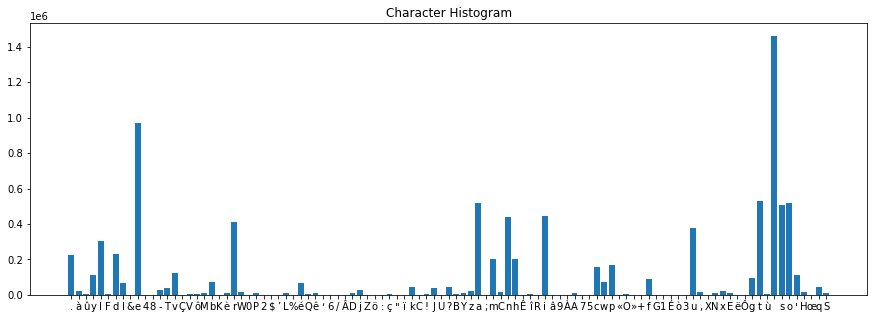

In [1559]:
corpus = ''.join(english+french)
count_letters = dict()

for c in all_chars:
    count_letters[c] = corpus.count(c)

plt.figure(figsize=(15,5))
plt.bar(range(len(count_letters)), list(count_letters.values()), align='center')
plt.xticks(range(len(count_letters)), list(count_letters.keys()))
plt.title("Character Histogram")
plt.show()

# Train

## Attention Decoder 
(Scroll down further to see how the simple decoder works.)


In [1571]:
N_SAMPLES = 1000 #len(english)
Xs, Ys = words_to_data(english[:N_SAMPLES], french[:N_SAMPLES], stoi, stop_char=STOP_CHR)


# MODEL
n_letters = len(stoi)
hidden_size = 128
emb_dim = 33

model = TranslGRU(vocab_size=n_letters,
                  enc_embed_dim=emb_dim,
                  dec_embed_dim=emb_dim,
                  dec_type="attention",
                  hidden_size=hidden_size,
                  max_length=MAX_CHARS,
                  stoi_mapping=stoi, 
                  start_chr=START_CHR, stop_chr=STOP_CHR
                  )
model.init_weights(lam=0.01)

print("MODEL PARAMETERS:", model.n_parameters)
print("training samples:", len(Xs))

MODEL PARAMETERS: 153866
training samples: 1000


In [1548]:
# Testing model on a single phrase
# (takes more iterations for longer phrases to be learned)
for _ in range(300):
    s = 1

    x, y = Xs[s], Ys[s]

    output, loss = model.forward(x, y, teacher_forcing_ratio=1)

    model.backprop_update(lr=0.1)

print(loss / len(y))
guess, true = model.decode_output(output, label=y)
print("Guess:", guess)
print("True:", true)
print("English:", ''.join([itos[i.item()] for i in x]))

tensor(0.0194, grad_fn=<DivBackward0>)
Guess: Cours !<
True: Cours !<
English: Run!<


In [1577]:
# Reset weights
model.init_weights(lam=0.01)

TFR = 0.5
print_every = 1
plot_every = 1
epochs = 10

loss_list = []

In [1582]:
strt = time.time()
for epoch in range(1, epochs):
    ep_loss = 0
    sample_ix = [i for i in range(0, N_SAMPLES)]
    random.shuffle(sample_ix)

    for sample in sample_ix:
        x, y = Xs[sample], Ys[sample]
        output, loss = model.forward(x, y, teacher_forcing_ratio=TFR)
        ep_loss += loss.item()

        model.backprop_update(lr=0.1)

    if epoch % print_every == 0:
        guess, true = model.decode_output(output, label=y)
        stp = time.time()

        print(f"({epoch}/{epochs}) Loss = {ep_loss/N_SAMPLES}")
        print("Guess:", guess)
        print("True:", true, end=" | ")
        print("English:", ''.join([itos[i.item()] for i in x]), end="  ")
        print(f"(elapsed: {round(stp-strt, 3)}s)")

        with open('train-log.txt', 'w') as f:
            f.write(f'epoch {epoch}; loss {ep_loss} \n')


    if epoch % plot_every == 0:
        loss_list.append(loss.item())

(1/10) Loss = 40.13181055617333
Guess: Jeeiseee  <
True: C'est moi qui l'ai fait.< | English: I did that.<  (elapsed: 15.051s)
(2/10) Loss = 35.84280650901795
Guess: Je s        
True: Je l’ai vu.< | English: I saw it.<  (elapsed: 28.613s)
(3/10) Loss = 33.63026506733895
Guess: Soue eeu  ee
True: Joli coup !< | English: Nice shot!<  (elapsed: 42.391s)
(4/10) Loss = 33.47911199855805
Guess: Je ie s ii<
True: Je suis timide.< | English: I'm timid.<  (elapsed: 56.497s)
(5/10) Loss = 32.693414268493655
Guess: Ee se s
True: Sors !< | English: Get out!<  (elapsed: 71.461s)
(6/10) Loss = 32.75629072713852
Guess: Reeee   <
True: Suis-moi.< | English: Follow me.<  (elapsed: 87.751s)
(7/10) Loss = 31.607102030277254
Guess: Dils--<
True: Trouvez un emploi !< | English: Get a job.<  (elapsed: 102.974s)
(8/10) Loss = 31.633027374267577
Guess: Qu          <
True: Qui est-il ?< | English: Who is it?<  (elapsed: 118.332s)
(9/10) Loss = 32.460661185264584
Guess: Je seis se <
True: Je vous ai vu.< | Eng

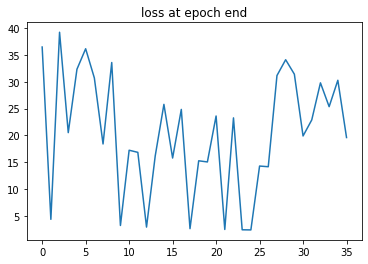

In [1586]:
plt.plot(loss_list)
plt.title("loss at epoch end")
plt.show()

In [1587]:
# Evaluate some training examples
for _ in range(5):
    i = random.randint(0, len(Xs)+1)
    eng = ''.join([itos[i.item()] for i in Xs[i]])
    guess = model.evaluate(eng)
    true = ''.join([itos[i.item()] for i in Ys[i]])
    print(eng, "---", guess, f"({true})")

I saw him.< --- Je se s ia  < (Je l’ai vu.<)
Who won?< --- Pui e       < (Qui a gagné ?<)
I lost it.< --- Je se s ia  < (Je l’ai perdu.<)
I've won.< --- Je suis ii < (J'ai gagné.<)
I can wait.< --- Je se s ia s< (Je peux attendre.<)


In [1589]:
model.evaluate("Hello!")

'Pi ee     <'

Needs some serious training.

---
## Simple Decoder
It's impressive to see this simple model work so effectively. Running on a single sample, the model can quickly learn how to  

In [1353]:
N_SAMPLES = 300
Xs, Ys = words_to_data(english[:N_SAMPLES], french[:N_SAMPLES], stoi, stop_char=STOP_CHR)


# MODEL
n_letters = len(stoi)
hidden_size = 64
emb_dim = 33
simple_model = TranslGRU(vocab_size=n_letters,
                  enc_embed_dim=emb_dim,
                  dec_embed_dim=emb_dim,
                  dec_type="simple",
                  hidden_size=hidden_size,
                  max_length=MAX_CHARS,
                  stoi_mapping=stoi, start_chr=START_CHR, stop_chr=STOP_CHR
                  )
simple_model.init_weights(lam=0.01)

print("MODEL PARAMETERS:", simple_model.n_parameters)
print("training samples:", len(Xs))

MODEL PARAMETERS: 51259
training samples: 300


### Learning a single phrase

In [1357]:
for _ in range(100):
    s = 1

    x, y = Xs[s], Ys[s]

    output, loss = simple_model.forward(x, y)

    simple_model.backprop_update(lr=0.1)

print(loss / len(y))
guess, true = simple_model.decode_output(output, label=y)
print("Guess:", guess)
print("True:", true)
print("English:", ''.join([itos[i.item()] for i in x]))

tensor(0.0652, grad_fn=<DivBackward0>)
Guess: Cours !<
True: Cours !<
English: Run!<


In [1360]:
# Reset weights
simple_model.init_weights(lam=0.01)
print_every = 10
plot_every = 1
iters = 100

loss_list = []

In [1361]:
for iter in range(1, iters):
    iter_loss = 0
    sample_ix = [i for i in range(0, N_SAMPLES)]
    random.shuffle(sample_ix)

    for sample in sample_ix:
        x, y = Xs[sample], Ys[sample]
        output, loss = simple_model.forward(x, y)
        iter_loss += loss.item()

        simple_model.backprop_update(lr=0.1)

    if iter % print_every == 0:
        print(f"({iter}/{iters}) Loss = {iter_loss/N_SAMPLES}")
        guess, true = simple_model.decode_output(output, label=y)
        print("Guess:", guess)
        print("True:", true, end=" | ")
        print("English:", ''.join([itos[i.item()] for i in x]))
    if iter % plot_every == 0:
        loss_list.append(loss.item())

(10/100) Loss = 29.109890333811443
Guess: Aoiseee  
True: Entrez !< | English: Come in.<
(20/100) Loss = 29.82682728767395
Guess: No s    ssss      
True: Il laissa tomber.< | English: He quit.<
(30/100) Loss = 101.82599234580994
Guess: Je msa t !os
True: J'ai froid.< | English: I'm cold.<
(40/100) Loss = 87.0341360727946
Guess: Auop leé
True: Venez !< | English: Come on.<
(50/100) Loss = 89.16821046153704
Guess: Aenenenenenenenene
True: Attendez un peu !< | English: Hang on!<
(60/100) Loss = 101.5166610622406
Guess: Je rtrn. iiiiii
True: Je suis libre.< | English: I'm free.<
(70/100) Loss = 87.4940610853831
Guess: Moe r<
True: Entre.< | English: Come in.<
(80/100) Loss = 93.55654497385025
Guess: Apppppppppp
True: Attendez !< | English: Wait!<
(90/100) Loss = 84.44904192209243
Guess: Sioum<
True: Il laissa tomber.< | English: He quit.<


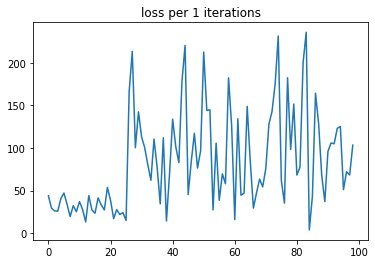

In [1362]:
plt.plot(loss_list)
plt.title(f"loss per {plot_every} iterations")
plt.show()

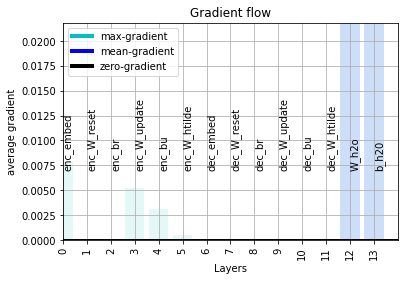

In [1363]:
plot_grad_flow_basic(simple_model.params, simple_model.param_names)